<a href="https://www.kaggle.com/code/sherrytp/melbourne-housing-outliers?scriptVersionId=126452980" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [51]:
np.random.seed(42)
n_feats = 4

In [52]:
np.random.normal(scale=10.0,size=(1000,n_feats))

array([[  4.96714153,  -1.38264301,   6.47688538,  15.23029856],
       [ -2.34153375,  -2.34136957,  15.79212816,   7.67434729],
       [ -4.69474386,   5.42560044,  -4.63417693,  -4.65729754],
       ...,
       [ 19.23445795,  -7.7461497 , -16.89183038,  -4.71263741],
       [-19.75487771,   7.51099455, -20.65083046,   0.28457581],
       [-20.7781182 ,  -3.20297805,  16.43378156,   3.60647891]])

In [5]:
import os 
os.getcwd()

'/kaggle/working'

In [69]:
MelbourneHousing = pd.read_csv('../input/melbourne-housing-market/Melbourne_housing_FULL.csv')

In [70]:
MelbourneHousing.fillna(MelbourneHousing.median(),inplace=True)

In [53]:
dummydf = pd.DataFrame(np.random.normal(scale=10.0,size=(1000,n_feats)),
                       columns=['feature{}'.format(i)for i in range(n_feats)])

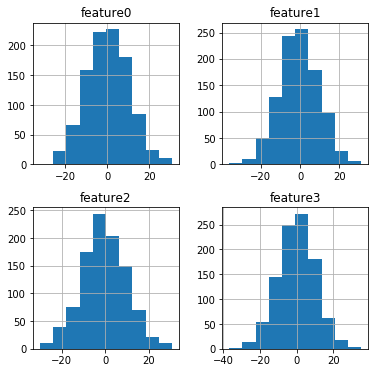

In [54]:
dummydf.hist(figsize=(6,6));


In [55]:
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.224978,-0.685717,-0.437810,-0.150958
std,10.183914,10.023596,10.183483,10.271558
min,-32.210164,-36.010851,-30.076323,-36.883653
25%,-6.927696,-7.456066,-7.074677,-6.715644
50%,-0.066807,-0.574566,-0.619886,0.032589
75%,7.443917,6.061648,6.537654,6.809758
max,30.982994,31.129102,30.768604,35.290552


In [56]:
def out_std(s, nstd=3.0,return_thresholds=False):
    data_mean,data_std = s.mean(),s.std()
    cut_off = data_std*nstd
    lower,upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower,upper
    else:
        return[True if x < lower or x > upper else False for x in s]
    

In [57]:
def out_iqr (s,k=1.5,return_thresholds = False):
    q25,q75 = np.percentile(s,25),np.percentile(s,75)
    iqr = q75 - q25
    cut_off =iqr * k
    lower , upper = q25 - cut_off,q75 + cut_off
    if return_thresholds:
        return lower , upper
    else:
        return[True if x <lower or x > upper else False for x in s]

In [58]:
outlier_mask = out_std(dummydf['feature0'],nstd = 3.0)

In [59]:
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

In [60]:
dummydf['feature0'][outlier_mask]

449    30.982994
785   -32.210164
Name: feature0, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


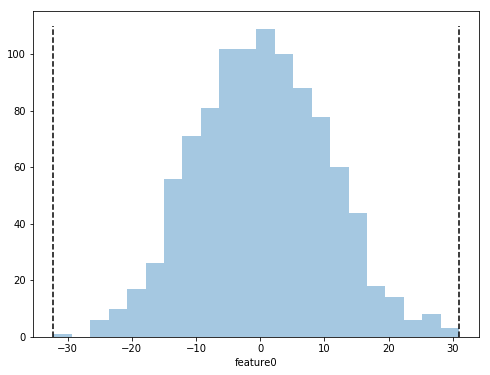

In [61]:
plt.figure(figsize=(8,6))
sns.distplot(dummydf['feature0'],kde=False);
plt.vlines(dummydf['feature0'][outlier_mask],ymin=0,ymax=110,linestyles='dashed');

In [62]:
std2 = dummydf.apply(out_std,nstd=2.0)
std3 = dummydf.apply(out_std,nstd=3.0)
std4 = dummydf.apply(out_std,nstd=4.0)

In [63]:
iqr1 = dummydf.apply(out_iqr, k=1.5)
iqr2 = dummydf.apply(out_iqr, k=2.0)
iqr3 = dummydf.apply(out_iqr, k=3.0)

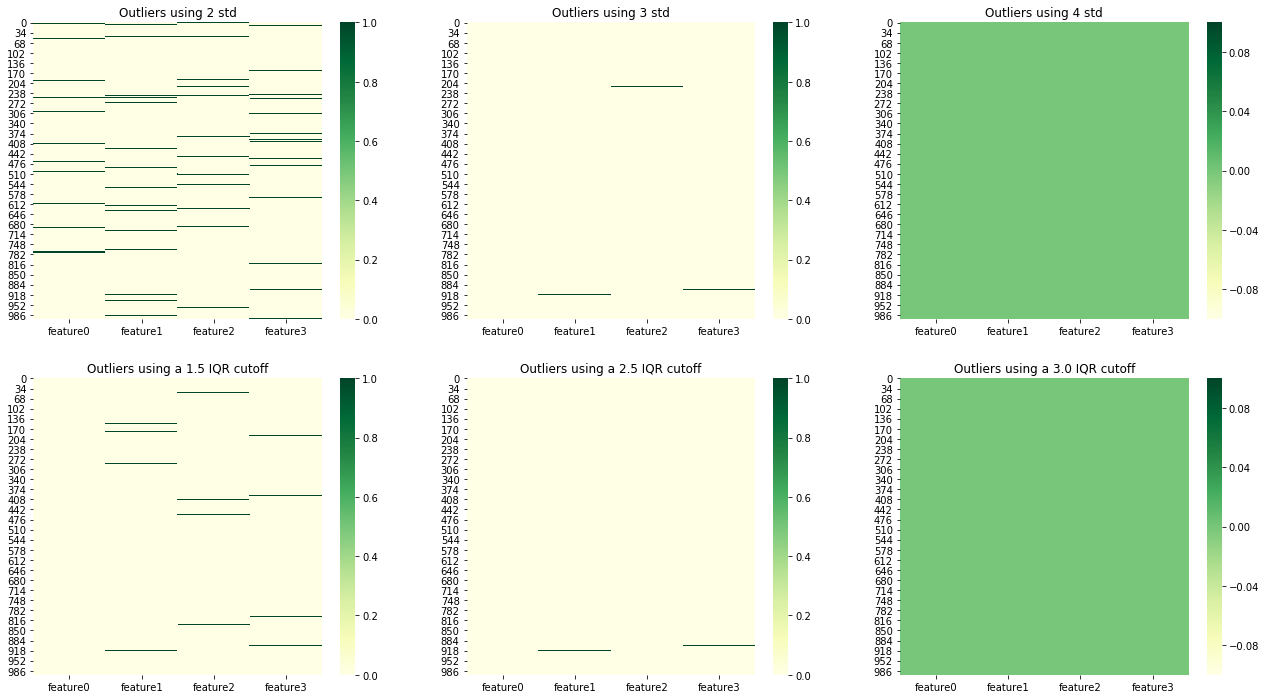

In [64]:
f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3,nrows=2,figsize=(22,12));
ax1.set_title('Outliers using 2 std');
ax2.set_title('Outliers using 3 std');
ax3.set_title('Outliers using 4 std');
ax4.set_title('Outliers using a 1.5 IQR cutoff');
ax5.set_title('Outliers using a 2.5 IQR cutoff');
ax6.set_title('Outliers using a 3.0 IQR cutoff');

sns.heatmap(std2,cmap='YlGn', ax=ax1);
sns.heatmap(std3,cmap='YlGn',ax=ax2);
sns.heatmap(std4,cmap='YlGn',ax=ax3);
sns.heatmap(iqr1,cmap='YlGn',ax=ax4);
sns.heatmap(iqr2,cmap='YlGn',ax=ax5);
sns.heatmap(iqr3,cmap='YlGn',ax=ax6);

plt.savefig('outlier.png')

plt.show()



In [65]:
def plot_cutoff(dataframe, col,nstd=2.0,color='red'):
    lower, upper = out_std(dataframe[col],nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col]< lower],default=dataframe[col]
                    .min()),lower,alpha=0.2,color=color);
    plt.axvspan(upper,max(dataframe[col][dataframe[col]>upper],default=dataframe[col].max()),
               alpha=0.2,color=color);

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


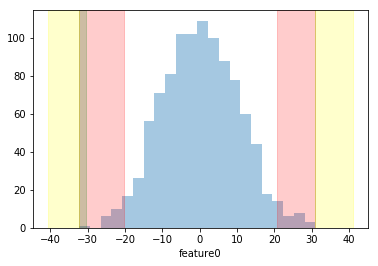

In [66]:
column = 'feature0'
sns.distplot(dummydf[column],kde=False)
plot_cutoff(dummydf,column,nstd=2.0,color='red');
plot_cutoff(dummydf,column,nstd=3.0,color='green');
plot_cutoff(dummydf,column,nstd=4.0,color='yellow');

In [71]:
cols = ['Rooms','Price','Distance','Bedroom2','Bathroom','Car','Landsize','Propertycount']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17d2feb8>,
      dtype=object)

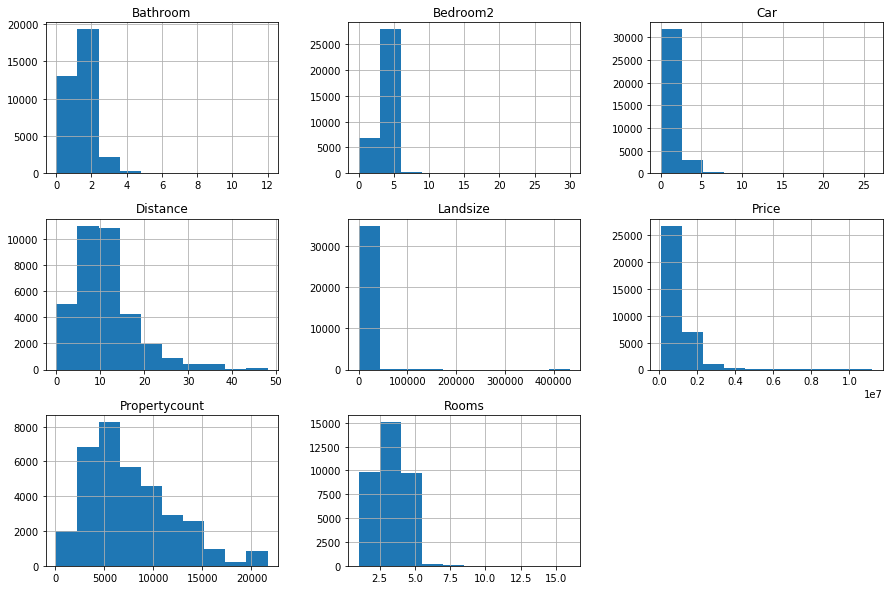

In [72]:
MelbourneHousing[cols].hist(figsize=(15,10))

In [77]:
MelbourneHousing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,870000.0,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,136.0,1970.0,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,136.0,1970.0,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,870000.0,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,136.0,1970.0,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

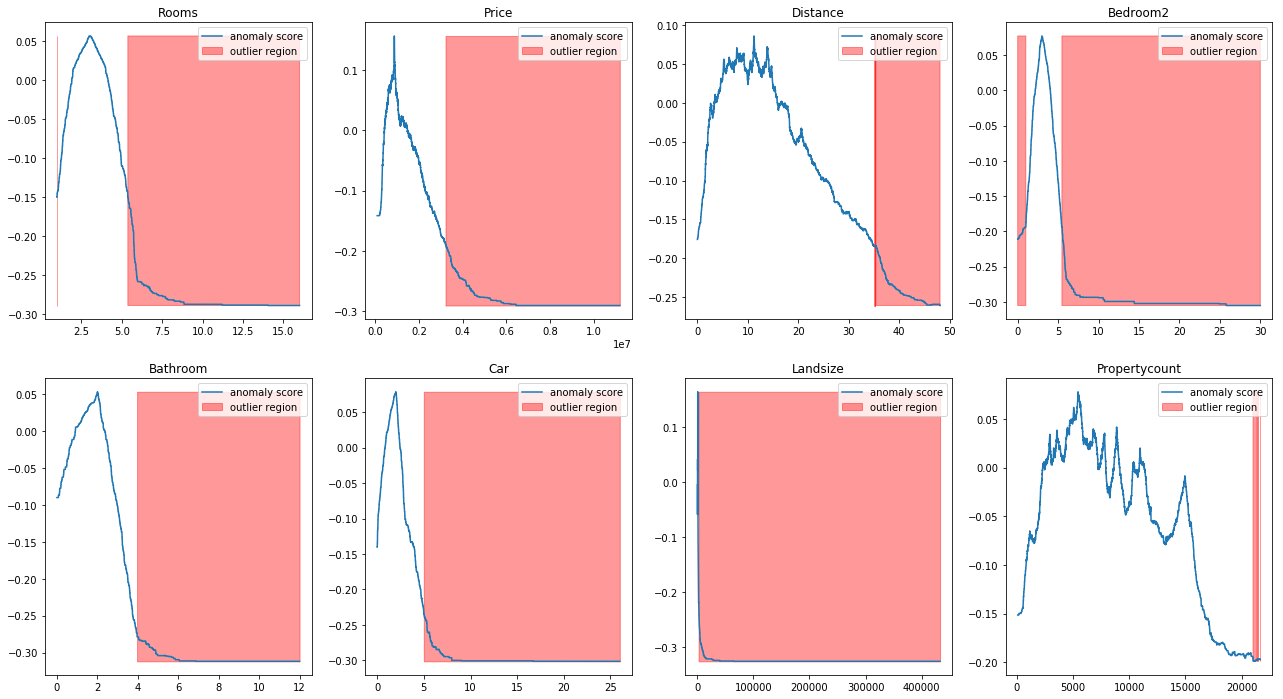

In [87]:
fig,axs = plt.subplots(2,4,figsize=(22,12),facecolor='w',edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.01)
    isolation_forest.fit(MelbourneHousing[column].values.reshape(-1,1))
    
    
    xx=np.linspace(MelbourneHousing[column].min(),MelbourneHousing[column].max(),
                   len(MelbourneHousing)).reshape(-1,1)

    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,anomaly_score,label='anomaly score')
    axs[i].fill_between(xx.T[0],np.min(anomaly_score),np.max(anomaly_score),where=outlier==-1,color='r'
                    ,alpha =.4,label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [89]:
clf = EllipticEnvelope()

legend = {}
xx,yy = np.meshgrid(np.linspace(-35,35,500),np.linspace(-35,35,500))
plt.figure(1,figsize=(10,10))
clf.fit(dummydf.values[:,:2])


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

<Figure size 720x720 with 0 Axes>

Text(0.5,0,'feature0')

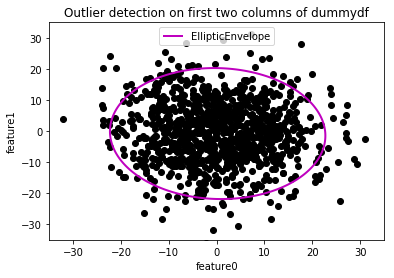

In [96]:
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(xx,yy,Z,levels=[0],linewidths=2,colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1,figsize=(10,10))
plt.title("Outlier detection on first two columns of dummydf")
plt.scatter(dummydf.values[:,0],dummydf.values[:,1],color='black')
bbox_args = dict(boxstyle="round",fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(),xx.max()))
plt.ylim((yy.min(),yy.max()))
plt.legend(legend_values_list[0].collections,legend_keys_list,loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0")



In [97]:
X = StandardScaler().fit_transform(MelbourneHousing[cols].values)

db=DBSCAN(eps=3.0,min_samples=10).fit(X)
labels = db.labels_


In [98]:
pd.Series(labels).value_counts()

 0    34797
-1       60
dtype: int64

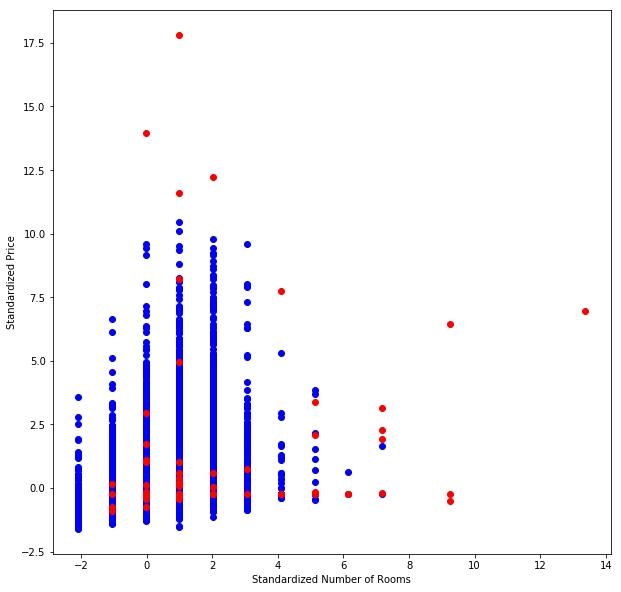

In [100]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue','red']

for color, label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask],X[:,1][sample_mask],'o',color=color);
    plt.xlabel('Standardized Number of Rooms');
    plt.ylabel('Standardized Price');

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


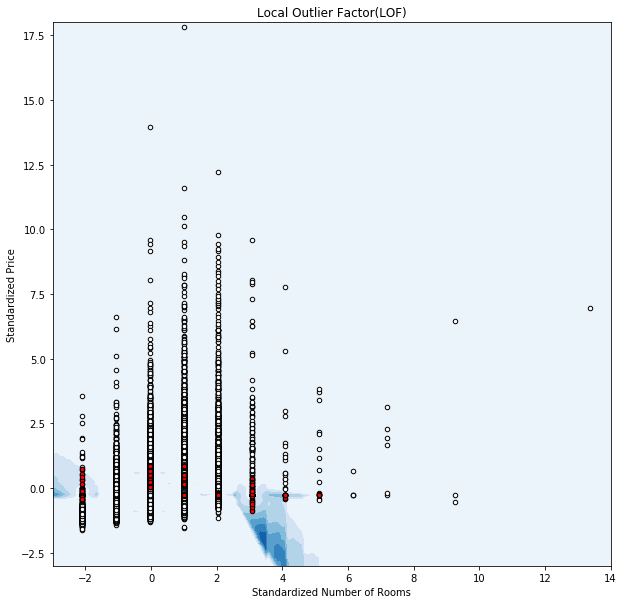

In [115]:
clf = LocalOutlierFactor (n_neighbors = 50,contamination=0.01)
y_pred = clf.fit_predict (X[:,:2])

plt.figure(figsize=(10,10))

xx,yy = np.meshgrid(np.linspace(-3,14,num=200),np.linspace(-3,18,num=200))
Z = clf._decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor(LOF)")
plt.contourf(xx,yy,Z,cmap=plt.cm.Blues_r)

a  = plt.scatter (X[in_mask, 0],X[in_mask,1],c = 'white', edgecolor='k',s=20)

b = plt.scatter (X[out_mask,0],X[out_mask,1],c = 'red',edgecolor='k',s=20)

plt.axis('tight')
plt.xlabel('Standardized Number of Rooms')
plt.ylabel('Standardized Price')
plt.show()
                                                                                                                                                 